In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
# tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
from ast import literal_eval
data_train = pd.read_pickle('drive/My Drive/Colab Notebooks/fakenews-master/data/news_proc_12_3_19.pickle')
data_train = data_train[['type', 'text', 'title']]
data_train['type'].unique()

array(['real', 'fake'], dtype=object)

In [0]:
data_train["text"]

0        [128, 2379, 1, 318, 12, 13034, 9413, 1631, 41,...
1        [6117, 4883, 13034, 3113, 2826, 4605, 1927, 33...
2        [446, 6117, 4883, 13034, 301, 11, 1790, 659, 8...
3        [741, 615, 1924, 2, 65, 675, 1639, 4, 469, 879...
4        [446, 6117, 4883, 13034, 783, 30, 831, 14896, ...
                               ...                        
19150    [1214, 6555, 31, 5472, 2724, 10729, 23, 12687,...
19151    [7, 2779, 4264, 17, 1742, 2717, 38413, 12, 168...
19152    [7, 268, 423, 162, 11, 917, 430, 1468, 3, 15, ...
19153    [9711, 494, 13595, 349, 8, 11, 618, 307, 1063,...
19154    [513, 1732, 13741, 59535, 13034, 2165, 1880, 1...
Name: text, Length: 19155, dtype: object

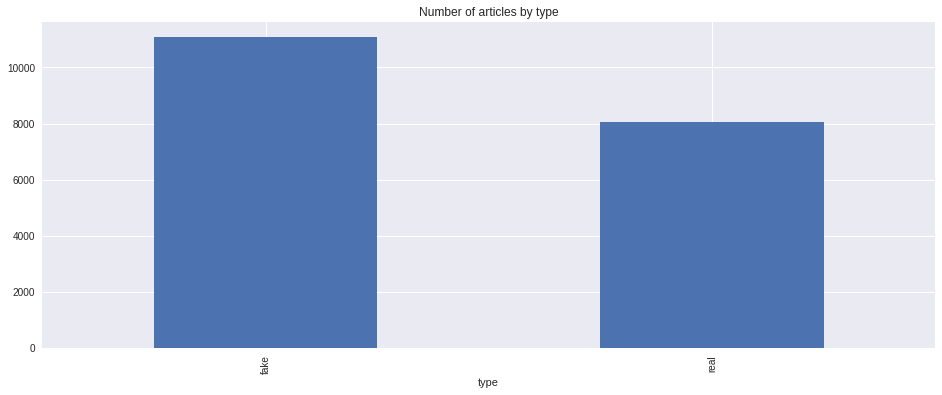

In [0]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
data_train.groupby("type").count()['text'].plot.bar(title = "Number of articles by type", ax = ax)

In [0]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/fakenews-master/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():  
    embed_mat[e.index] = model[i]

In [0]:
len_content = len(data_train['text'][0])
len_title = len(data_train['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 8045
Max len title: 93


In [0]:
news1['type'] = news1['type'].map({'fake': 1, 'real': 0})

In [0]:
news1['type'].unique()

array([0, 1])

In [0]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    news1[['text', 'title']], news1['type'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [0]:
X_train_title = X_train['title']
X_train_content = X_train['text']

X_valid_title = X_valid['title']
X_valid_content = X_valid['text']

X_test_title = X_test['title']
X_test_content = X_test['text']


In [0]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]
len(valid_fit[0])

4023

In [0]:
#Optimum params for CNN network
params_cnn = {
    'lr': 0.23993334664040306,
    'momentum': 0.30361299021107185,
    'dropout1': 0.10993063833594595,
    'dropout2': 0.1586041045258562,
    'filters1Title': 8,
    'denseTitle': 42,
    'filtersContent': 6,
    'denseContent': 34
}

In [0]:
#Some imports...
import tensorflow as tf
import os

from numpy.random import seed
from tensorflow import set_random_seed

In [0]:
seed(50)
set_random_seed(50)
#k.backend.clear_session()

In [0]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='categorical_crossentropy', metrics=['acc'])
model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 93)]         0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      [(None, 8045)]       0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 93, 300)      15000000    title_input[0][0]                

In [0]:

train_fit_copy = train_fit
train_fit_new = [train_fit[0][:9216]]
# len(train_fit_copy[1][:9216])
train_fit_new.append(train_fit_copy[1][:9216])
len(train_fit_new[0]) 
train_fit = train_fit_new
y_train = y_train[:9216]
y_train = np.asarray(y_train).reshape((-1,1))

In [0]:

hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64,epochs=25,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.01)], 
                 validation_data=(valid_fit, np.array(y_valid.tolist())))

Train on 9216 samples, validate on 4023 samples
Epoch 1/25


InvalidArgumentError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import keras

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Model

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3978811115064333765
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9422908153147127362
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [0]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [0]:
from ast import literal_eval
data_train = pd.read_pickle('drive/My Drive/Colab Notebooks/fakenews-master/data/news_proc_12_3_19.pickle')
data_train = data_train[['type', 'text', 'title']]
data_train['type'].unique()

array(['real', 'fake'], dtype=object)

In [0]:
data_train['type'] = data_train['type'].replace('fake',1)
data_train['type'] = data_train['type'].replace('real',0)

In [0]:
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text1 = data_train.title[i]
    text2 = data_train.text[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.type[i])

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43449 unique tokens.


In [0]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [0]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Shape of data tensor: (19155, 1000)
Shape of label tensor: (19155, 2)


In [0]:
# Train test validation Split
from sklearn.model_selection import train_test_split
print(type(data))
indices = np.arange(len(data))
print(indices)
np.random.shuffle(indices)
l = []
d = []
for each in indices:
  d.append(data[each])
  l.append(labels[each])
data =np.asarray(d)
labels = np.asarray(l)
print(type(data[0]))
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

# print('real & fake news in train,valt,test:')
# print(y_train.sum(axis=0))
# print(y_val.sum(axis=0))
# print(y_test.sum(axis=0))


<class 'numpy.ndarray'>
[    0     1     2 ... 19152 19153 19154]
<class 'numpy.ndarray'>
Size of train, validation, test: 15324 9578 9577


In [0]:
GLOVE_DIR = "drive/My Drive/Colab Notebooks/fakenews-master/data/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [0]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()



Fitting the simple convolutional neural network model
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         4345000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1

In [0]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15324 samples, validate on 9578 samples
Epoch 1/3
15324/15324 [==============================] - 207s 14ms/step - loss: 0.6865 - acc: 0.5743 - val_loss: 0.6889 - val_acc: 0.5763
Epoch 2/3
15324/15324 [==============================] - 207s 14ms/step - loss: 0.6827 - acc: 0.5769 - val_loss: 0.6810 - val_acc: 0.5763
Epoch 3/3
15324/15324 [==============================] - 208s 14ms/step - loss: 0.6813 - acc: 0.5781 - val_loss: 0.6816 - val_acc: 0.5763
